In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.linalg import solve_discrete_are

In [41]:
T = 0.005 # 5ms
z_c = 0.814 #m
g = 9.8
N_l = 250
H_time = 7 # s
x0 = np.zeros((3,1))
A = np.array([[1, T, T**2/2],[0, 1, T], [0, 0, 1]])
B = np.array([[T**3/6],[T**2/2], [T]])
C = np.array([[1, 0, -z_c/g]])
Q_x = np.zeros((A.shape[0],A.shape[0]))
Q_e = np.array([[1]])
R = np.array([[1e-6]])

## System Dynamics:
$$
\dot X = \begin{bmatrix}0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0\end{bmatrix} X + \begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix} u_x
\\
y = \begin{bmatrix}1 & 0 & -\frac{z_c}{g}\end{bmatrix}X
$$
where $X=\begin{bmatrix}x \\ \dot x \\ \ddot x\end{bmatrix}$. The discretized dynamics is,
$$
X_{k+1} = \begin{bmatrix}1 & T & \frac{T^2}{2} \\ 0 & 1 & T \\ 0 & 0 & 1\end{bmatrix} X_k + \begin{bmatrix}\frac{T^3}{6} \\ \frac{T^2}{2} \\ T\end{bmatrix} u_k
\\
y_k = \begin{bmatrix}1 & 0 & -\frac{z_c}{g}\end{bmatrix}X_k
$$

## Trajectory Optimization Problem:
$$
\Delta u_k^* = \operatorname{argmin}_{\Delta u_k} J
$$

$$
J = \sum_{i=k}^{\infty} (Q_e e_i^2+\Delta x_i^TQ_x \Delta x_i+R\Delta u_i^2)
$$
where $e(i)=y_i - y^d_i$, $\Delta x_i = x_i - x_{i-1}$, and $\Delta u_i=u_i - u_{i-1}$.
To solve this problem, we need to re-write the system dynamics based on an assumption that we have access to $N_L$ future samples of $y^d$,
$$
\tilde X_{k+1} = \begin{bmatrix}1 & 1 & T & \frac{T^2}{2}-\frac{z_c}{g}\\ 0 & 1 & T & \frac{T^2}{2} \\ 0 & 0 & 1 & T\\ 0 & 0 & 0 & 1\end{bmatrix} \tilde X_k + \begin{bmatrix}\frac{T^3}{6} - \frac{Tz_c}{g}\\ \frac{T^3}{6} \\ \frac{T^2}{2} \\ T\end{bmatrix} \Delta u_i 
$$
where $\tilde x_k=\begin{bmatrix}e_k\\ \Delta x_k\end{bmatrix}$. Then the cost function will become,
$$
J=\sum_{i=k}^{\infty} (\Delta \tilde x_i^T\tilde Q \tilde x_i+R\Delta u_i^2)
$$
After solving the optimization problem, the optimal incremental control will be,
$$
\Delta u_k = -G_I e_k - G_x \Delta x_k - \sum_{l=1}^{N_L} G_d(l) y_d(k+l)
$$
where
$$
G_I = [R+\tilde B^T \tilde K \tilde B]^{-1}\tilde B^T \tilde K \tilde I
\\
G_x = [R+\tilde B^T \tilde K \tilde B]^{-1}\tilde B^T \tilde K \tilde F
\\
G_d(1) = -G_I
\\
G_d(l) = [R+\tilde B^T \tilde K \tilde B]^{-1}\tilde B^T \tilde X(l-1), l=2,...,N_L
$$
where
$$
\tilde K = \tilde A^T \tilde K \tilde A-\tilde A^T \tilde K \tilde B [R+\tilde B^T \tilde K \tilde B]^{-1}\tilde B^T \tilde K \tilde A + \tilde Q
\\
\tilde X(l)=\tilde A_c^T \tilde X(l-1), l=2,...,N_L; \tilde X(1)=-\tilde A_c^T \tilde K \tilde I
\\
\tilde A_c = \tilde A - \tilde B[R+\tilde B^T \tilde K \tilde B]^{-1} \tilde B^T \tilde K \tilde A
$$

In [85]:
def system(x0, T, Horizon, A, B, C, G_I, G_x, G_d, y_ref):
    X = [x0]
    X_out = [x0[0,:]]
    Y = []
    Y_out = []
    for i in range(int(Horizon//T)):
        Y.append(C@X[i])
        Y_out.append(Y[i].squeeze())
        u = cal_u(G_I, G_x, G_d, X, Y, y_ref)
        X.append(A@X[i]+B@u)
        X_out.append(X[i][0,:].squeeze())
    return X_out, Y_out

def cal_u(G_I, G_x, G_d, X, Y, y_ref):
    u = 0
    for i in range(len(X)):
        u -= G_I@(Y[i]-y_ref[i])
    for i in range(len(G_d)):
        u -= G_d[i]@y_ref[len(X)-1+i]
    u -= G_x@X[-1]
    return u

def zmp_ref_generator(T, Horizon, N_l):
    x = []
    y = []
    t = []
    for i in range(int(Horizon//T) + N_l):
        t.append(i*T)
        if i < (3//T):
            x.append([0])
        elif i < (4//T):
            x.append([0.3])
        elif i < (5//T):
            x.append([0.6])
        elif i < (6//T):
            x.append([0.9])
        else:
            x.append([0.9])
        if i < (2//T):
            y.append([0])
        elif i < (3//T):
            y.append([0.1])
        elif i < (4//T):
            y.append([-0.1])
        elif i < (5//T):
            y.append([0.1])
        elif i < (6//T):
            y.append([-0.1])
        else:
            y.append([0])
    return x, y, t

def opt_incrementa_control(A, B, C, Q_e, Q_x, R, N_l):
    B_t = C@B
    B_t = np.vstack([B_t, B])
    
    I_t = np.ones(Q_e.shape[0])
    I_t = np.vstack([I_t, np.zeros((A.shape[0],1))])
    
    F_t = C@A
    F_t = np.vstack([F_t, A])
    
    Q_t = block_diag(Q_e,Q_x)
    
    A_t = np.hstack([I_t,F_t])
    
    K_t = solve_discrete_are(A_t, B_t, Q_t, R)
    
    A_c_t = A_t - B_t@np.linalg.inv(R+B_t.T@K_t@B_t)@B_t.T@K_t@A_t
    
    G_I = np.linalg.inv(R + B_t.T@K_t@B_t)@ B_t.T@K_t@I_t
    G_x = np.linalg.inv(R + B_t.T@K_t@B_t)@ B_t.T@K_t@F_t
    
    G_d = []
    G_d.append(-G_I)
    X_t = -A_c_t.T@K_t@I_t
    for i in range(2,N_l):
        G_d.append(np.linalg.inv(R+B_t.T@K_t@B_t)@B_t.T@X_t)
        X_t = A_c_t.T@X_t
    return G_I, G_x, G_d
    

In [86]:
x_ref, y_ref, t = zmp_ref_generator(T, H_time, N_l)

In [87]:
G_I, G_x, G_d = opt_incrementa_control(A, B, C, Q_e, Q_x, R, N_l)

In [80]:
'''
plt.figure(4)
plt.plot(G_d.reshape(-1,1))
plt.xlabel('time')
plt.ylabel('Preview Gain')
plt.show()
'''

TypeError: list indices must be integers or slices, not tuple

In [88]:
x_com, x_zmp = system(x0, T, H_time, A, B, C, G_I, G_x, G_d, x_ref)
y_com, y_zmp = system(x0, T, H_time, A, B, C, G_I, G_x, G_d, y_ref)

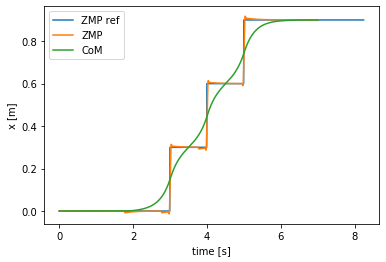

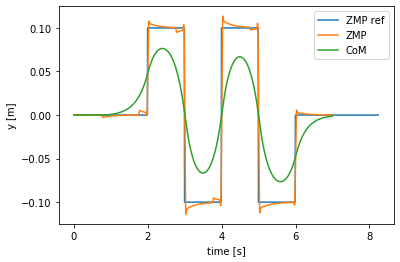

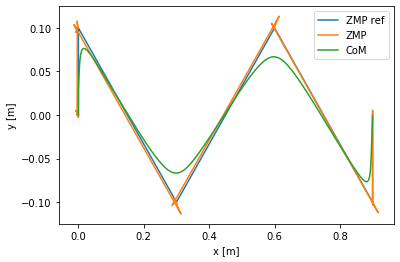

In [91]:
plt.figure(1)
plt.plot(t, x_ref, label='ZMP ref')
plt.plot(t[:len(x_zmp)], x_zmp, label='ZMP')
plt.plot(t[:len(x_com)], x_com, label='CoM')
plt.xlabel('time [s]')
plt.ylabel('x [m]')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(t, y_ref, label='ZMP ref')
plt.plot(t[:len(y_zmp)], y_zmp, label='ZMP')
plt.plot(t[:len(y_com)], y_com, label='CoM')
plt.xlabel('time [s]')
plt.ylabel('y [m]')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(x_ref, y_ref, label='ZMP ref')
plt.plot(x_zmp, y_zmp, label='ZMP')
plt.plot(x_com, y_com, label='CoM')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.show()

## Limitations:
1. Fixed footsteps, which can not be changed
2. The height of CoM is constant